In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets
import toolbox as tb
import kaggleData as kD

Populating the interactive namespace from numpy and matplotlib


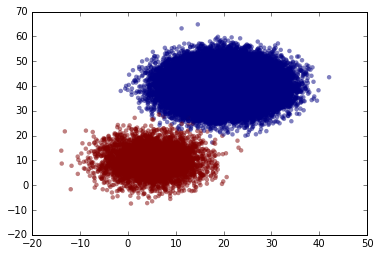

In [2]:
#toydata shall have n vectors with 5 dimensions
n = 100000
#probability for signal-label
s_prob = 0.05
dim = 4
data = tb.createToyData(n,dim,s_prob)
weights = data[:,0]
labels = data[:,1]
x_1 = data[:,2]
x_2 = data[:,3]

%pylab inline
plt.scatter(x_1, x_2, edgecolor="", c=labels, alpha=0.5)

For Comparison, we calculate the best possible AMS    
(case: every signal correctly detected)

In [3]:
tb.calcMaxAMS(weights,labels);

Found 5103 signals.
Weightsums signal: 128.574986048 | background: 0
Maximum AMS possible with this Data: 21.712420857088706


prepare (=normalize) data

In [4]:
X=data[:,2:4]
X /= np.max(np.abs(X),axis=0)

In [5]:
n_train = int(n/10)

train_X,test_X = tb.splitList(X,n_train)
train_labels,test_labels = tb.splitList(labels,n_train)
test_weights = tb.splitList(weights,n_train)[1]

In [6]:
tb.calcMaxAMS(test_weights,test_labels);

Found 4624 signals.
Weightsums signal: 116.396254829 | background: 0
Maximum AMS possible with this Data: 20.211403246300478


classify with knN

In [10]:
neigh = neighbors.KNeighborsClassifier(n_neighbors=5,n_jobs=4)
neigh.fit(train_X,train_labels)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=4, n_neighbors=5, p=2,
           weights='uniform')

In [11]:
test_X[:,1]

array([ 0.60525043,  0.64678825,  0.70953328, ...,  0.53349223,
        0.63136289,  0.6828433 ])

In [12]:
pred = neigh.predict(test_X)

Populating the interactive namespace from numpy and matplotlib


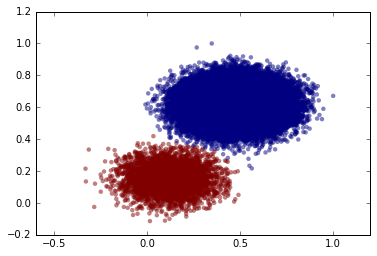

In [13]:
%pylab inline
plt.scatter(test_X[:,0], test_X[:,1], edgecolor="", c=pred, alpha=0.5)

In [14]:
s,b = tb.calcWeightSums(test_weights,pred,test_labels)
print("AMS:",tb.calcAMS(s,b))

AMS: 18.995403606045763


Let's use Kaggle-Data:

In [15]:
#csvDict,header = kD.createCsvDictionary();

In [16]:
(header,
 test_data,
 test_weights,
 test_labels,
 train_data,
 train_weights,
 train_labels) = kD.getWholeDataSet(kSet="v")

In [21]:
train_eventList,test_eventList = kD.getFeatureSets("EventId",header,test_data,train_data)

features with good properties

In [34]:
(train_DER_mass_MMC,
 test_DER_mass_MMC) = kD.getFeatureSets("DER_mass_MMC",header,test_data,train_data)
(train_DER_mass_transverse_met_lep,
 test_DER_mass_transverse_met_lep) = kD.getFeatureSets("DER_mass_transverse_met_lep",header,test_data,train_data)
(train_DER_mass_vis,
 test_DER_mass_vis) = kD.getFeatureSets("DER_mass_vis",header,test_data,train_data)

(train_DER_met_phi_centrality,
 test_DER_met_phi_centrality) = kD.getFeatureSets("DER_met_phi_centrality",header,test_data,train_data)
(train_DER_pt_ratio_lep_tau,
 test_DER_pt_ratio_lep_tau) = kD.getFeatureSets("DER_pt_ratio_lep_tau",header,test_data,train_data)
(train_PRI_tau_pt,
 test_PRI_tau_pt) = kD.getFeatureSets("PRI_tau_pt",header,test_data,train_data)
(train_DER_pt_h,
 test_DER_pt_h) = kD.getFeatureSets("DER_pt_h",header,test_data,train_data)

In [22]:
train_labels = np.array(train_labels).transpose()
test_labels = np.array(test_labels).transpose()

In [23]:
tb.calcMaxAMS(test_weights,test_labels);

Found 153683 signals.
Weightsums signal: 691.988607714 | background: 0
Maximum AMS possible with this Data: 67.71112289514149


In [24]:
train_X_1 = train_DER_met_phi_centrality
train_X_2 = train_DER_pt_ratio_lep_tau

train_X = np.zeros(shape = (len(train_X_1),2),dtype=float)
train_X[:,0] = train_X_1[:]
train_X[:,1] = train_X_2[:]

In [25]:
test_X_1 = test_DER_met_phi_centrality
test_X_2 = test_DER_pt_ratio_lep_tau

test_X = np.zeros(shape = (len(test_X_1),2),dtype=float)
test_X[:,0] = test_X_1[:]
test_X[:,1] = test_X_2[:]

In [28]:
neigh = neighbors.KNeighborsClassifier(n_neighbors=20,n_jobs=4)
neigh.fit(train_X,train_labels)
pred = neigh.predict(test_X)

In [29]:
s,b = tb.calcWeightSums(test_weights,pred,test_labels)
print("AMS:",tb.calcAMS(s,b))

AMS: 1.2586050379166098


improvement by simple normalization of data

In [31]:
train_X_1 /= np.max(np.abs(train_X_1),axis=0)
train_X_2 /= np.max(np.abs(train_X_2),axis=0)
train_X[:,0] = train_X_1[:]
train_X[:,1] = train_X_2[:]
test_X_1 /= np.max(np.abs(test_X_1),axis=0)
test_X_2 /= np.max(np.abs(test_X_2),axis=0)
test_X[:,0] = test_X_1[:]
test_X[:,1] = test_X_2[:]
neigh = neighbors.KNeighborsClassifier(n_neighbors=20,n_jobs=4)
neigh.fit(train_X,train_labels)
pred = neigh.predict(test_X)
s,b = tb.calcWeightSums(test_weights,pred,test_labels)
print("AMS:",tb.calcAMS(s,b))

AMS: 1.3009807199985761


In [32]:
def getBestN(n_range,train_X,test_X,test_weights,test_labels):
    maxAMS = 0
    bestN = 0
    neigh = neighbors.KNeighborsClassifier(weights='distance',n_jobs=4)
    for n in n_range:
        neigh.set_params(n_neighbors=n)
        neigh.fit(train_X,train_labels)
        pred = neigh.predict(test_X)
        s,b = tb.calcWeightSums(test_weights,pred,test_labels)
        ams = tb.calcAMS(s,b)
        print("n=", n, "| AMS:",ams)
        if ams > maxAMS:
            maxAMS = ams
            bestN = n
    return maxAMS,bestN

In [33]:
maxAMS, bestN = getBestN([1,5,10,20,50,100,200],train_X,test_X,test_weights,test_labels)
print("Best AMS:", maxAMS, "with n =", bestN)

n= 1 | AMS: 0.9702755151931686
n= 5 | AMS: 1.0599012759421942
n= 10 | AMS: 1.1184470543645095
n= 20 | AMS: 1.1865538396083004
n= 50 | AMS: 1.2632387701567622
n= 100 | AMS: 1.311147288978149
n= 200 | AMS: 1.3450976856297794
Best AMS: 1.3450976856297794 with n = 200


In [ ]:
train_X = np.array(
    [train_PRI_tau_pt,
     train_DER_met_phi_centrality,
     train_DER_pt_h,
     train_DER_pt_ratio_lep_tau]).transpose()
test_X = np.array(
    [test_PRI_tau_pt,
     test_DER_met_phi_centrality,
     test_DER_pt_h,
     test_DER_pt_ratio_lep_tau]).transpose()

In [ ]:
maxAMS, bestN = getBestN([1,5,10,20,50,100,200],train_X,test_X,test_weights,test_labels)
print("Best AMS:", maxAMS, "with n =", bestN)

data-normalization

In [ ]:
train_X_1 = train_PRI_tau_pt / np.max(np.abs(train_PRI_tau_pt),axis=0)
test_X_1 = test_PRI_tau_pt / np.max(np.abs(test_PRI_tau_pt),axis=0)

train_X_2 = train_DER_met_phi_centrality / np.max(np.abs(train_DER_met_phi_centrality),axis=0)
test_X_2 = test_DER_met_phi_centrality / np.max(np.abs(test_DER_met_phi_centrality),axis=0)

train_X_3 = train_DER_pt_h / np.max(np.abs(train_DER_pt_h),axis=0)
test_X_3 = test_DER_pt_h / np.max(np.abs(test_DER_pt_h),axis=0)

train_X_4 = train_DER_pt_ratio_lep_tau / np.max(np.abs(train_DER_pt_ratio_lep_tau),axis=0)
test_X_4 = test_DER_pt_ratio_lep_tau / np.max(np.abs(test_DER_pt_ratio_lep_tau),axis=0)

In [ ]:
train_X = np.array(
    [train_X_1,
     train_X_2,
     train_X_3,
     train_X_4]).transpose()
test_X = np.array(
    [test_X_1,
     test_X_2,
     test_X_3,
     test_X_4]).transpose()

In [ ]:
maxAMS, bestN = getBestN([1,5,10,20,50,100,200],train_X,test_X,test_weights,test_labels)
print("Best AMS:", maxAMS, "with n =", bestN)

In [ ]:
featList = ['DER_mass_MMC','DER_mass_transverse_met_lep','DER_mass_vis']
(new_header,new_test_data,new_test_weights,new_test_labels) = kD.getCustomDataSet(featList,kSet = "v")
(new_header,new_train_data,new_train_weights,new_train_labels) = kD.getCustomDataSet(featList,kSet = "t")

In [ ]:
maxAMS, bestN = getBestN([1,5,10,20,50,100,200],new_train_data,new_test_data,new_test_weights,new_test_labels)
print("Best AMS:", maxAMS, "with n =", bestN)

rank 1389!

normalized

In [ ]:
new_test_data[:,0] = new_test_data[:,0] / np.max(np.abs(new_test_data[:,0]),axis=0)
new_test_data[:,1] = new_test_data[:,1] / np.max(np.abs(new_test_data[:,1]),axis=0)
new_test_data[:,2] = new_test_data[:,2] / np.max(np.abs(new_test_data[:,2]),axis=0)

new_train_data[:,0] = new_train_data[:,0] / np.max(np.abs(new_train_data[:,0]),axis=0)
new_train_data[:,1] = new_train_data[:,1] / np.max(np.abs(new_train_data[:,1]),axis=0)
new_train_data[:,2] = new_train_data[:,2] / np.max(np.abs(new_train_data[:,2]),axis=0)

In [ ]:
maxAMS, bestN = getBestN([1,5,10,20,50,100,200],new_train_data,new_test_data,new_test_weights,new_test_labels)
print("Best AMS:", maxAMS, "with n =", bestN)

In [ ]:
train_1=np.zeros(np.shape(train_1))
test_1=np.zeros(np.shape(test_1))

train_1[:,0]=new_train_data[:,0]
train_1[:,1]=new_train_data[:,1]
test_1[:,0]=new_test_data[:,0]
test_1[:,1]=new_test_data[:,1]

In [ ]:
maxAMS, bestN = getBestN([1,5,10,20,50,100,200],train_1,test_1,new_test_weights,new_test_labels)
print("Best AMS:", maxAMS, "with n =", bestN)

In [ ]:
train_1=np.zeros(np.shape(train_1))
test_1=np.zeros(np.shape(test_1))

train_1[:,0]=new_train_data[:,1]
train_1[:,1]=new_train_data[:,2]
test_1[:,0]=new_test_data[:,1]
test_1[:,1]=new_test_data[:,2]

In [ ]:
maxAMS, bestN = getBestN([1,5,10,20,50,100,200],train_1,test_1,new_test_weights,new_test_labels)
print("Best AMS:", maxAMS, "with n =", bestN)

whole dataset

In [35]:
train_X = np.array(
    [train_DER_mass_MMC,
     train_DER_mass_transverse_met_lep,
     train_DER_mass_vis,
     train_DER_met_phi_centrality,
     train_DER_pt_ratio_lep_tau,
     train_PRI_tau_pt,
     train_DER_pt_h]).transpose()
test_X = np.array(
    [test_DER_mass_MMC,
     test_DER_mass_transverse_met_lep,
     test_DER_mass_vis,
     test_DER_met_phi_centrality,
     test_DER_pt_ratio_lep_tau,
     test_PRI_tau_pt,
     test_DER_pt_h]).transpose()

In [36]:
maxAMS, bestN = getBestN([1,5,10,20,50,100,200],train_X,test_X,test_weights,test_labels)
print("Best AMS:", maxAMS, "with n =", bestN)

n= 1 | AMS: 1.7968609973670682
n= 5 | AMS: 2.3004617231364217
n= 10 | AMS: 2.467656219578796
n= 20 | AMS: 2.5985659796761285
n= 50 | AMS: 2.6701882434159283
n= 100 | AMS: 2.683126682981207
n= 200 | AMS: 2.6837447784374833
Best AMS: 2.6837447784374833 with n = 200


rank #1278

In [37]:
#all but events, pls
train_x = train_data[:,1:-1]
test_x = test_data[:,1:-1]

In [ ]:
maxAMS, bestN = getBestN([1,5,10,20,50,100,200],train_x,test_x,test_weights,test_labels)
print("Best AMS:", maxAMS, "with n =", bestN)

n= 1 | AMS: 1.7708858729972399
n= 5 | AMS: 2.280574874803311
n= 10 | AMS: 2.426564206678323
n=